In [1]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
from PIL import Image,ImageEnhance

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

In [3]:
def load_midas_model(model_type):
    midas = torch.hub.load("intel-isl/MiDaS",model_type)
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    midas.to(device)
    midas.eval()
    midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

    if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
        transform = midas_transforms.dpt_transform
    else:
        transform = midas_transforms.small_transform
    return device,midas,transform

In [4]:
device, midas,transform = load_midas_model(model_type)

Using cache found in C:\Users\cyrie/.cache\torch\hub\intel-isl_MiDaS_master
Using cache found in C:\Users\cyrie/.cache\torch\hub\intel-isl_MiDaS_master


In [5]:
def estimate_depth_from_RGB_image(img):
    input_batch = transform(img).to(device)
    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
    output = prediction.cpu().numpy()
    return img, output

In [6]:
def convert_img_for_o3d(img):
    return Image.fromarray(img).convert("L")

In [7]:
def show_RGB_depth_image(rgb_image,depth_image):
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(rgb_image)
    plt.subplot(122)
    plt.imshow(depth_image)

In [8]:
def create_point_cloud_from_RGB_depth_images(RGB_image,depth_image):
    image_o3d = o3d.geometry.Image(RGB_image)
    depth_o3d = o3d.geometry.Image(depth_image)
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(image_o3d, depth_o3d)
    height, width,_ = RGB_image.shape
    pinhole_cam = o3d.open3d.camera.PinholeCameraIntrinsic(width= width, height=height, cx=640,cy=360,fx=500,fy=500)
    
    point_cloud = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image,pinhole_cam)
    return rgbd_image,point_cloud

In [9]:
path_image_1 = "assets/brosse.jpg"
path_image_2 = "assets/brosse2.jpg"

img1 = cv2.imread(path_image_1,cv2.IMREAD_COLOR)
img2 = cv2.imread(path_image_2,cv2.IMREAD_COLOR)
RGB_image_1,depth_img_1 = estimate_depth_from_RGB_image(img1)
RGB_image_2,depth_img_2 = estimate_depth_from_RGB_image(img2)

D:\Anaconda\lib\site-packages\torch\nn\functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


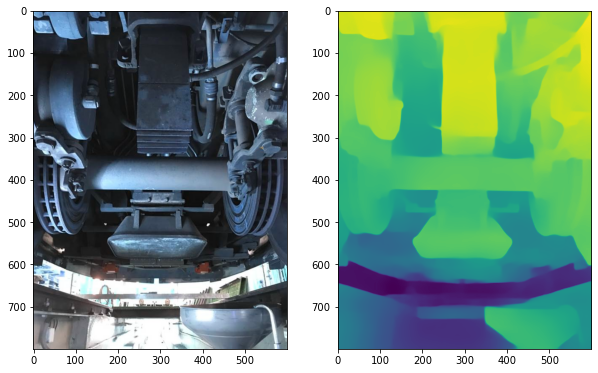

In [10]:
im = convert_img_for_o3d(depth_img_1)

show_RGB_depth_image(RGB_image_1,depth_img_1)

In [17]:
print(depth_img_1[200,300])
print(depth_img_1[620,10])



22.59502
1.4104083


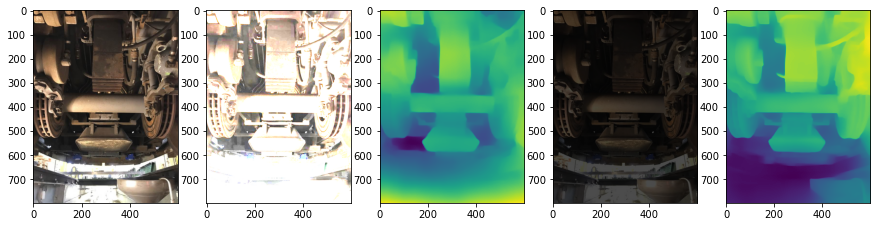

In [11]:
# Test différentes luminosités
img = Image.open(path_image_1,'r')
enhancer = ImageEnhance.Brightness(img)

img_bright = enhancer.enhance(5)
img_bright = np.array(img_bright)

enhancer = ImageEnhance.Brightness(img)

img_dark = enhancer.enhance(0.3)
img_dark = np.array(img_dark)

plt.figure(figsize=(15,15))
plt.subplot(151)
plt.imshow(img)
plt.subplot(152)
plt.imshow(img_bright)

_,img_d = estimate_depth_from_RGB_image(img_bright)
plt.subplot(153)
plt.imshow(img_d)

_,img_d2 = estimate_depth_from_RGB_image(img_dark)
plt.subplot(154)
plt.imshow(img_dark)
plt.subplot(155)
plt.imshow(img_d2)


In [18]:
rgbd_image,point_cloud = create_point_cloud_from_RGB_depth_images(RGB_image_1,depth_img_1)

In [ ]:
o3d.visualization.draw_geometries([point_cloud])

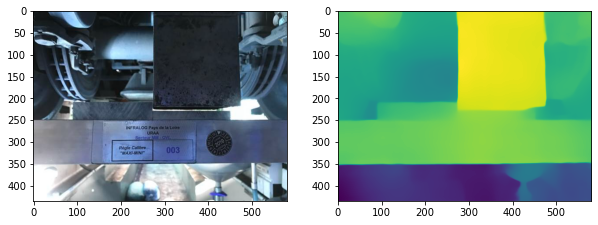

In [30]:
im = convert_img_for_o3d(depth_img_2)

show_RGB_depth_image(RGB_image_2,depth_img_2)

In [ ]:
rgbd_image_2,point_cloud_2 = create_point_cloud_from_RGB_depth_images(RGB_image_2,depth_img_2)

In [ ]:
o3d.visualization.draw_geometries([point_cloud_2])